### Sentiment analysis of tweets regarding female sports

In this study, we first try by extracting tweets with the help of hashtags used to refer to female performances in general. This is done within a certain period.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tweepy
import re
import string
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
#Twitter credentials for the app
consumer_key = 'XXXXXXXXXXXXXXXX'
consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_key= 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'


In [3]:
#pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [86]:
#declare file paths as follows for three files
femaleS_tweets = "data2/Sports/femalesports2.csv"

In [87]:
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
'favorite_count', 'retweet_count', 'original_author',   'possibly_sensitive', 'hashtags',
'user_mentions', 'place', 'place_coord_boundaries']

In [88]:
#set two date variables for date range
start_date = '2018-10-01'
end_date = '2019-12-27'

In [89]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])


# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])


#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)


#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [90]:
#method to clean_tweets()
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
 
    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
 
 
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
 
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
 
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)

In [95]:
#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    #page attribute in tweepy.cursor and iteration
    #api = tweepy.API(auth)
    #places = api.geo_search(query="FRANCE", granularity="country") Here I wanted to precise tweets from France only, but did not work with pagination
    #place_id = places[0].id
    for page in tweepy.Cursor(api.search, q=keyword, #(q="place:%s" % place_id), q=keyword,
                              count=200, include_rts=False, since=start_date).pages(50):
        for status in page:
            new_entry = []
            status = status._json
 
            ## check whether the tweet is in english or skip to the next tweet
            if status['lang'] != 'en':
                continue
 
            #when run the code, below code replaces the retweet amount and
            #no of favorires that are changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue
 
 
           #tweepy preprocessing called for basic preprocessing
            clean_text = status['text'] # p.clean(status['text'])
 
            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(clean_text)
 
            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
 
            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity
 
            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]
 
            #to append original author of the tweet
            new_entry.append(status['user']['screen_name'])
 
            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None
            new_entry.append(is_sensitive)
 
            # hashtagas and mentiones are saved using comma separted
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)
 
            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)
 
            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)
 
            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")

In [96]:
#declare keywords as a query for three categories
femaleS_keywords = '#femalesports OR #girlsports OR #femalefootball OR #femalebasket OR #femaleboxing OR #femaletournament OR #femalevoleyball OR #womeninsport OR #womensfootball'# OR #thisgirlcan'

In [97]:
#call main method passing keywords and file path
write_tweets(femaleS_keywords,  femaleS_tweets)

### ANALYSIS OF THE EXTRACTED DATA

In [98]:
femaleS_tweets1 = "data2/Sports/femalesports2.csv"

In [99]:
df1 = pd.read_csv(femaleS_tweets1) 

In [100]:
for col in df1.columns: 
    print(col)
  

id
created_at
source
original_text
clean_text
sentiment
polarity
subjectivity
lang
favorite_count
retweet_count
original_author
possibly_sensitive
hashtags
user_mentions
place
place_coord_boundaries


In [101]:
places = df1.place #== "France"
polarity = df1.polarity

In [102]:
#vector_places = []
#for col in places: 
#    print(col)
#    vector_places.append(col)
  #The tweets are coming from the following places:
data_places=pd.DataFrame(vector_places, columns=['Places'])

Goa, India
Arizona
Beverly Hills, CA
Calgary
Portsmouth
Sydney
Ottawa
Austin, TX
Sudbury, ON
nan
Gainesville, FL
East Midlands, England
United Kingdom
Montreal
Portlaoise, Co Laois.
Mumbai
Portlaoise
Sligo, Ireland
Harlow
Botswana
nan
Gainesville, FL
Southern California
Loughborough, England
nan
Hertfordshire, England
nan
United States
Western Massachusetts
Adelaide Sth Australia
Belbroughton
Adelaide
Kaurna Land, Adelaide
Saltash, Cornwall
Johannesburg
South Australia 
Pakistan
United States
nan
Delaware, USA
Derrylaughan - Ireland
nan
Sydney, New South Wales
England, United Kingdom
United Kingdom
Gone fishing
Cardiff, UK
ÜT: 45.487434,-74.314264
Cardiff, UK
Blackburn, England
nan
Ballarat, Victoria, Australia
Somewhere
Bengaluru, India
nan
Sudbury, ON
Durham, England 🏴󠁧󠁢󠁥󠁮󠁧󠁿
nan
Concord, NH
Teesside - Manchester
Barcelona
ÜT: -26.027069,28.028218
South Africa
West Campus, Sturrock Park
nan
Manchester
nan
Gold Coast Australia
nan
Global
Australia
nan
nan
Chester, UK
UK
Essex via East 

Blacksburg, VA
Balbriggan
Naarm, Australia.
nan
Gacha Hell
dumpster fire
nan
Virginia, USA
Iowa City, IA
Connecticut, USA
Fiction Land
São Paulo, Brasil
Perry, MI
nan
Manhattan
nan
Palo Alto, CA
Glasgow
nan
nan
Bedford, TX
Seattle, WA
nan
Sunshine Coast, Queensland
Connecticut, USA
600 w Cermak
Sport Updates
Milwaukee, WI
Oakland, CA
Chicago, IL
nan
🇦🇺🇨🇭
London
st pete, fl
nan
San Jose, CA
Olympia, WA
Monterrey
Si me pierdo me estoy encontrando
nan
nan
nan
nan
queer and confused | she/her
nan
Las Vegas, NV
United States
Melbourne, Victoria
Fairfax, VA, US
Earth
Pittsburgh, PA
Cork, Ireland
what would leslie knope do
Melbourne, Australia
Michigan, USA
Likely where live music is
nan
Round Rock, TX
nan
nan
SouthWestEngland & SouthWales
nan
Charlotte, NC
Michoacán, MX
Boston
BBVA Compass Stadium or Houston Sports Park
nan
Houston, TX
Uptown, New Orleans
Gainesville, FL
Ireland 
she/her • 18
nan
Australia
Benavides TX 
Portlaoise
Merced ➡ San Jose
New Jersey, USA
New Jersey
NYC
nan
minneapo

England, United Kingdom
England, United Kingdom
London
Bristol, United Kingdom
Crawley, South East
nan
España
Sydney, Australia
nan
nan
Bideford, Devon 
Brisbane, Australia 
Wherever the ball rolls
Belarus
nan
nan
Tadworth
Berry, New South Wales
nan
Berry, New South Wales
South Africa
Johannesburg 
nan
nan
Sydney, Australia
Cooloola Coast, Australia
nan
nan
nan
nan
nan
nan
Australia
Australia
East Midlands, England
México
Australia
Toronto, Ontario
wherever the snow takes me
where ever the snow takes me
Melbourne, Australia
nan
Ottawa, Ontario
Melbourne, Australia
Wurundjeri land, Australia
nan
Sydney, New South Wales
nan
Australia
At your fingertips
East Midlands, England
Toronto, Ontario
nan
Dominican Republic
East.L.A., Cali.
NY
University of Central Lancs'
Tadworth
nan
Toronto, Ontario
nan
London
University of Central Lancs'
University of Central Lancs'
Toronto, Ontario
Geneva, Switzerland
Manchester, England
Melbourne, Australia
Melbourne, Australia
Penrith, NSW Australia
nan
Melb

In [103]:
data_places

,Places
0,"Goa, India"
1,Arizona
2,"Beverly Hills, CA"
3,Calgary
4,Portsmouth
...,...
3775,NaN
3776,"Wexford, Ireland"
3777,"North East, England"
3778,NaN


In [104]:
file1 = "data2/Sports/tweet_places2.csv"
csvFile = open(file1, 'a' ,encoding='utf-8')
data_places.to_csv(csvFile, mode='a', columns=['Places'], index=False, encoding="utf-8")

In [106]:
for sent in polarity:
    print(sent)

1.0
0.0
0.2857142857142857
0.2954545454545455
0.0
0.0
0.0
0.0
0.0
0.0
0.13636363636363635
0.0
-0.25
0.0
1.0
0.0
1.0
0.08333333333333333
0.14999999999999994
0.125
0.2090909090909091
0.0
0.0
0.4166666666666666
0.0
0.14999999999999994
0.125
0.0
0.0
-0.5
0.25
-0.5
-0.5
0.0
0.13333333333333333
-0.5
0.0
0.0
-0.5
0.3250000000000001
0.0
-0.3333333333333333
-0.25
0.0
0.06818181818181818
0.0
0.35416666666666663
0.0
0.35416666666666663
0.0
0.0
0.0
0.0
0.0
0.375
0.2
0.0
0.0
0.0
0.375
0.2090909090909091
0.13333333333333333
0.13333333333333333
0.13333333333333333
0.0
0.0
0.0
0.0
-0.10000000000000002
0.35000000000000003
0.0
-0.10000000000000002
0.0
0.4285714285714286
0.375
0.0
0.0
0.13636363636363635
0.0
0.3250000000000001
0.2
0.0
-0.35
0.5
0.65
0.0
0.0
0.35
0.13636363636363635
0.13636363636363635
0.0
0.3250000000000001
0.0
0.15
0.15
0.37777777777777777
0.0
0.0
-0.3
-2.7755575615628914e-17
0.2090909090909091
0.2
0.3
0.20656565656565654
-0.10000000000000002
0.0
0.0
0.0
0.425
0.0
0.0
0.0
-0.25
0.468181

0.25
0.25
0.25
0.9
0.25
0.25
0.25
0.25
0.25
0.25
0.0
0.25
-0.4513888888888888
0.25
0.13636363636363635
0.13636363636363635
0.2681818181818182
0.13636363636363635
0.25
0.25
0.25
0.25
0.25
0.1
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.18333333333333332
0.25
0.25
0.15
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.04999999999999997
0.1875
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.18333333333333332
0.25
0.25
0.25
0.15
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.18333333333333332
0.25
0.16666666666666666
0.0
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.4
0.25
0.25
0.25
0.15
0.25
0.16666666666666666
0.25
0.25
0.25
0.25
0.25
0.25
0.125
0.25
0.25
0.25
0.25
-0.125
0.25
0.25
0.2
0.25
0.25
0.25
0.5
0.25
0.25
0.25
0.25
0.0
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.125
0.25
0.25
0.25
0.25
0.25
0.0
0.25
0.5
0.25
0.25
0.25
0.0
0.25
0.25
0.0
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.16666666666666666
0.25
0.25
0.25
0.25
-0.4
0.25
0.25
0.15
0.25
0.25
0.25
0.25
0.25
0.16666666666666666
0.25
0.25
0.25
0.25
0.

1.0
0.0
0.5
0.6
1.0
1.0
1.0
1.0
1.0
1.0
-0.4
-0.25
0.6
0.4
0.5625
-0.25
-0.25
0.5625
0.4
0.6
-0.4
-0.25
0.5625
-0.4
-0.4
0.5625
0.0
0.2111111111111111
-0.04166666666666666
0.21666666666666667
0.05
0.21666666666666667
-0.3
0.2444444444444445
0.25
0.5625
0.5
0.14444444444444446
0.3181818181818182
0.0
0.0
0.21666666666666667
0.0
0.0
0.0
0.0
0.125
0.15
-0.04166666666666666
0.0
0.0
0.0
-0.08333333333333333
0.0
0.0
0.6
0.21666666666666667
-0.075
0.5
0.20833333333333331
0.0
0.0
0.21666666666666667
0.0
0.0
-0.3
0.2
0.0
0.4
0.2
0.16666666666666666
0.0
0.175
-0.16666666666666666
0.4
0.0
0.0
0.0
0.0
0.0
0.21666666666666667
0.25
0.5625
0.5833333333333334
0.5
0.0
0.11818181818181818
0.2
0.6000000000000001
0.0
0.6000000000000001
0.2
0.0
0.2
0.07878787878787878
0.0
-0.012500000000000013
0.0
0.2
0.0
0.2
0.2
0.2
0.175
0.6000000000000001
0.0
0.175
0.2
0.2
0.2
0.6000000000000001
0.2
0.0
0.7000000000000001
0.2
0.2
0.2
0.2
0.0
0.2
-0.4
0.2
0.0
0.11818181818181818
0.2
0.2
0.2556818181818182
0.25568181818181

In [107]:
vector_of_sentiments = []
a = 0
polarity = df1.polarity
for sent in polarity:
    if float(sent) > 0:
        print('Positive')
        a = 1
        vector_of_sentiments.append(a)
    else:
        print('Negative')
        a = 0
        vector_of_sentiments.append(a)
    #print("")

Positive
Negative
Positive
Positive
Negative
Negative
Negative
Negative
Negative
Negative
Positive
Negative
Negative
Negative
Positive
Negative
Positive
Positive
Positive
Positive
Positive
Negative
Negative
Positive
Negative
Positive
Positive
Negative
Negative
Negative
Positive
Negative
Negative
Negative
Positive
Negative
Negative
Negative
Negative
Positive
Negative
Negative
Negative
Negative
Positive
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Negative
Negative
Positive
Positive
Negative
Negative
Negative
Positive
Positive
Positive
Positive
Positive
Negative
Negative
Negative
Negative
Negative
Positive
Negative
Negative
Negative
Positive
Positive
Negative
Negative
Positive
Negative
Positive
Positive
Negative
Negative
Positive
Positive
Negative
Negative
Positive
Positive
Positive
Negative
Positive
Negative
Positive
Positive
Positive
Negative
Negative
Negative
Negative
Positive
Positive
Positive
Positive
Negative
Negative
Negative
Negative
Positive
Negative
Negative
N

Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Negative
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Negative
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Negative
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Negative
Positive
Positive
Positive
Positive
Positive
Negative
Positive
Positive
Negative
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Negative
Positive
Positive
Positive
Positive
P

Positive
Positive
Positive
Positive
Positive
Negative
Positive
Positive
Positive
Positive
Positive
Negative
Positive
Negative
Positive
Negative
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Negative
Negative
Negative
Negative
Positive
Negative
Negative
Positive
Negative
Positive
Positive
Positive
Positive
Negative
Positive
Negative
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Negative
Negative
Negative
Negative
Positive
Negative
Negative
Negative
Negative
Negative
Negative
Positive
Positive
Negative
Positive
Negative
Positive
Positive
Negative
Positive
Positive
Positive
Negative
Negative
Positive
Negative
Negative
Negative
Negative
Negative
Positive
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Positive
Negative
Positive
Positive
Positive
Positive
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Negative
Positive
Positive
Negative
Negative
Negative
Negative
Negative
Negative
Negative
Negative
Negative
Negative
Negative
N

In [108]:
#print('The sentiment vector is:', vector_of_sentiments)
print('The number of positives is:', vector_of_sentiments.count(1))
print('The number of negatives is:', vector_of_sentiments.count(0))

The number of positives is: 2554
The number of negatives is: 1226


[1226 2554]


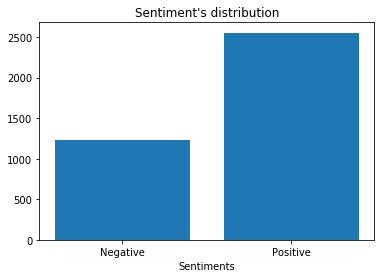

In [109]:
labels, counts = np.unique(vector_of_sentiments, return_counts=True)
print(counts)
labels1 = ["Negative","Positive"]
plt.bar(labels1, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel("Sentiments")
plt.title("Sentiment's distribution")
plt.show()

We observed that we have more positive comments than negative ones :)